# 200716 Genome counts



In [47]:
import numpy as np
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

## Load data

In [2]:
df = pd.read_csv("/Users/student/notebooks/midas/taxonomy.csv").set_index('key')

## Count genomes

In [3]:
genera = sorted(df['genus'].unique())
n_genera = len(genera)
genus_to_idx = {g: i for i, g in enumerate(genera)}

species = sorted({(r['genus'], r['species']) for k, r in df.iterrows()})
n_species = len(species)
species_to_idx = {s: i for i, s in enumerate(species)}

len(genera), len(species)

(419, 1438)

In [4]:
genus_idxs = [genus_to_idx[genus] for genus in df['genus']]
species_idxs = [species_to_idx[(row['genus'], row['species'])] for k, row in df.iterrows()]

genus_counts = np.bincount(genus_idxs)
species_counts = np.bincount(species_idxs)

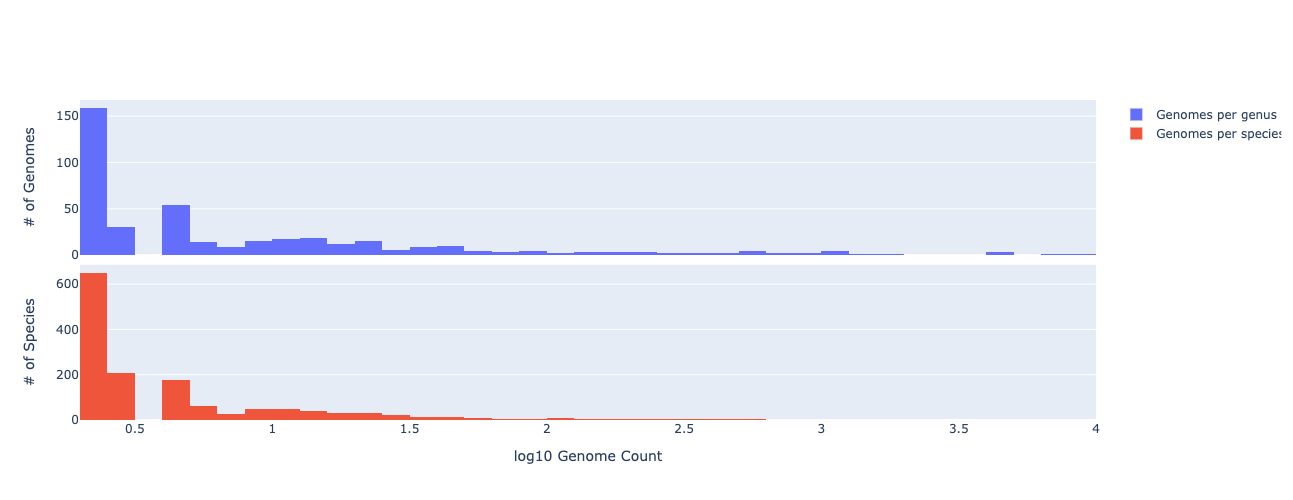

In [108]:
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.03)

fig.add_trace(
    go.Histogram(
        x=np.log10(genus_counts),
        name='Genomes per genus',
        bingroup=1,
    ),
    row=1, col=1
)

fig.add_trace(
    go.Histogram(
        x=np.log10(species_counts),
        name='Genomes per species',
        bingroup=1,
    ),
    row=2, col=1
)

fig.update_xaxes(title_text="log10 Genome Count", row=2, col=1)
fig.update_yaxes(title_text='# of Genomes', row=1, col=1)
fig.update_yaxes(title_text='# of Species', row=2, col=1)
fig.update_layout(width=1000, height=500)

fig

In [6]:
counts_df = df.groupby(['genus', 'species']).size().reset_index(name='genomes')

## Summarize

In [76]:
def make_counts_summary(max_genera=25, min_genera_size=100, max_species=5, min_species_size=40, include_all=False):
    rows = []
    genus_argsort = np.argsort(genus_counts)[::-1]
    
    n_genera_show = min(sum(genus_counts >= min_genera_size), max_genera)
    # Avoid "(1 additional genera)"
    if n_genera_show == n_genera - 1:
        n_genera_show = n_genera

    for gidx in genus_argsort[:max_genera]:
        genus = genera[gidx]

        gdf = counts_df[counts_df['genus'] == genus].sort_values('genomes', ascending=False)
        
        n_sp = gdf.shape[0]
        genus_count = gdf['genomes'].sum()
        
        if genus_count < min_genera_size:
            break
        
        if include_all:
            rows.append((genus, '(all species)', genus_count))

        n_sp_show = min(sum(gdf['genomes'] >= min_species_size), max_species)
        # Avoid "(1 additional species)"
        if n_sp_show == n_sp - 1:
            n_sp_show = n_sp
            
        if n_sp_show == 0:
            continue
        
        nrem = genus_count
        for i in range(n_sp_show):
            _, species, count = gdf.iloc[i]
                
            rows.append((genus, species, count))
            nrem -= count
            
        if nrem:
            rows.append((genus, '(%d additional species)' % (n_sp - n_sp_show), nrem))
            
    rows.append((
        '(%d additional genera)' % (n_genera - n_genera_show),
        '(%d additional species)' % genus_counts[n_genera_show:].sum(),
        genus_counts[n_genera_show:].sum(),
    ))
            
    return pd.DataFrame.from_records(rows, columns=['genus', 'species', 'genomes'])

In [77]:
with pd.option_context('display.max_rows', 9999):
    display(make_counts_summary(include_all=True).set_index(['genus', 'species']))

genomes
genus                   species                            
Streptococcus           (all species)                  9518
                        pneumoniae                     7099
                        suis                            853
                        agalactiae                      622
                        pyogenes                        249
                        equi                            243
                        (29 additional species)         452
Staphylococcus          (all species)                  7027
                        aureus                         6497
                        epidermidis                     306
                        haemolyticus                    129
                        (18 additional species)          95
Salmonella              (all species)                  4653
                        enterica                       4650
                        bongori                           3
Escherichia             (all species)                  4259
                        coli                           4221
                        (2 additional species)           38
Mycobacterium           (all species)                  4002
                        tuberculosis                   3486
                        abscessus                       241
                        avium                            91
                        bovis                            66
                        (26 additional species)         118
Pseudomonas             (all species)                  1904
                        aeruginosa                     1547
                        syringae                        114
                        (32 additional species)         243
Acinetobacter           (all species)                  1476
                        baumannii                      1277
                        pittii                           62
                        (26 additional species)         137
Vibrio                  (all species)                  1158
                        parahaemolyticus                474
                        cholerae                        437
                        (29 additional species)         247
Neisseria               (all species)                  1063
                        meningitidis                    721
                        gonorrhoeae                     326
                        (5 additional species)           16
Klebsiella              (all species)                  1021
                        pneumoniae                      877
                        [Enterobacter] aerogenes        108
                        (2 additional species)           36
Burkholderia            (all species)                  1001
                        pseudomallei                    392
                        ubonensis                       252
                        cepacia                          65
                        stagnalis                        63
                        mallei                           46
                        (14 additional species)         183
Campylobacter           (all species)                   934
                        jejuni                          628
                        coli                            257
                        (8 additional species)           49
Enterococcus            (all species)                   919
                        faecalis                        433
                        faecium                         412
                        (21 additional species)          74
Shigella                (all species)                   686
                        sonnei                          563
                        flexneri                        104
                        (2 additional species)           19
Listeria                (all species)                   647
                        monocytogenes                   624
                        (6 addit

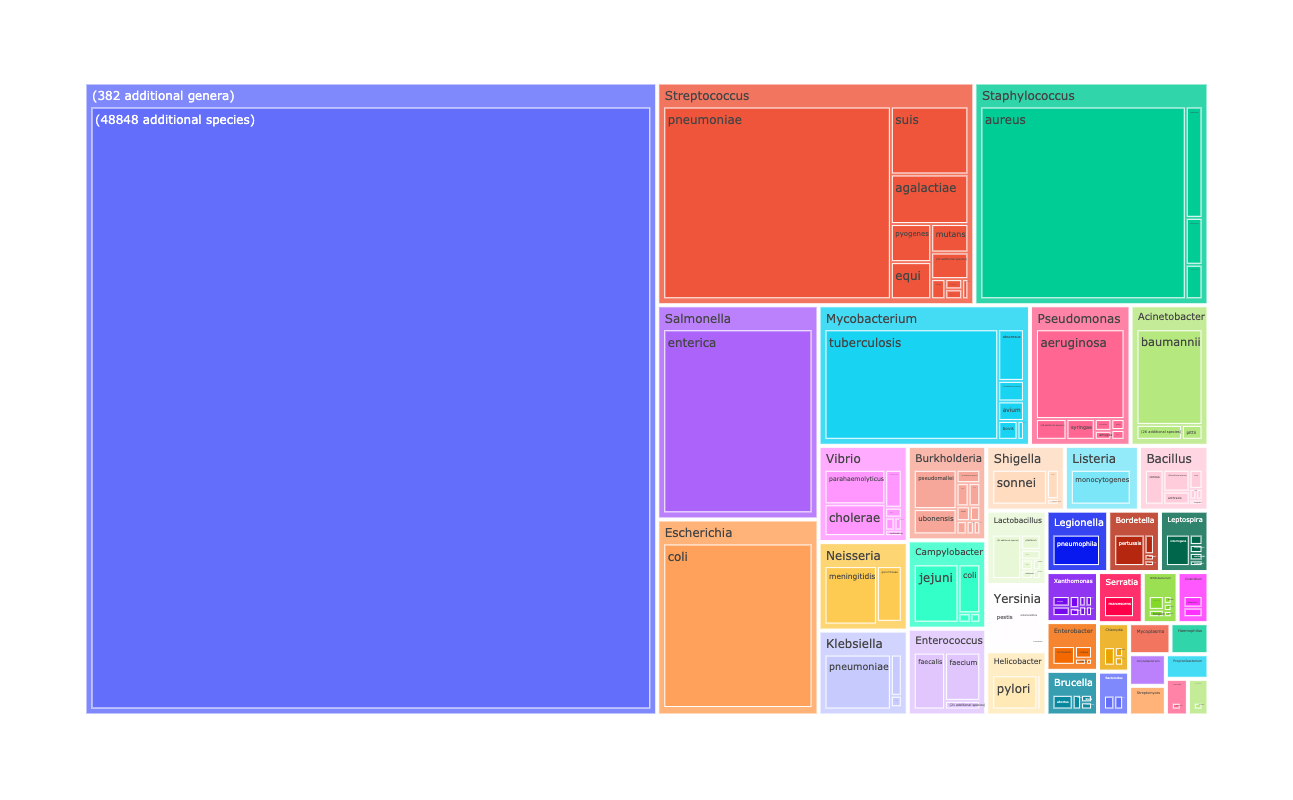

In [75]:
cdf = make_counts_summary(min_species_size=20, max_species=20, max_genera=400)
# cdf.drop(index=cdf.index[-1], inplace=True)

fig = px.treemap(
    cdf,
    path=['genus', 'species'],
    values='genomes',
    width=1200, height=800)

# px.treemap() doesn't accept this argument for some reason
tm, = fig.select_traces()
tm.hovertemplate='<b>%{label}</b> <br>%{value} genomes'

fig